In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.linear_model import LinearRegression
from fill_data_gap_helpers import *

pd.set_option('display.max_rows', 8)
!

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
ls /ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/ | grep lsff_estimated_data_plus_covariates_with_nutrient

lsff_estimated_data_plus_covariates_with_nutrient_3_14_2021.csv
lsff_estimated_data_plus_covariates_with_nutrient_3_22_2021.csv
lsff_estimated_data_plus_covariates_with_nutrient_3_26_2021.csv


In [3]:
path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_estimated_data_plus_covariates_with_nutrient_3_26_2021.csv'

In [4]:
df = pd.read_csv(path)
df = df[['location_id','location_name', 'vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_vehicle', 'nutrient',
       'percent_of_population_eating_fortified_vehicle',
       'sodium', 'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id']]
df.head()

,location_id,location_name,vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_vehicle,nutrient,percent_of_population_eating_fortified_vehicle,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all,parent_id
0,161.0,Bangladesh,oil,88.4,95.0,vitamin a,25.623416,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
1,161.0,Bangladesh,oil,88.4,95.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
2,161.0,Bangladesh,oil,88.4,89.0,vitamin a,25.623416,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
3,161.0,Bangladesh,oil,88.4,89.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
4,161.0,Bangladesh,oil,88.4,75.0,vitamin a,25.623416,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159


In [5]:
all_locs = set(df.location_name)

In [6]:
def prep_reg_estimates(path):
    draws = [f'draw_{i}' for i in range(500)]

    df = pd.read_csv(path)
    df = df.groupby(['location_name','vehicle']).mean().reset_index()
    df['value_mean'] = df[draws].mean(axis=1)
    df['value_025_percentile'] = df[draws].quantile(.025, axis=1)
    df['value_975_percentile'] = df[draws].quantile(.975, axis=1)

    return df[['location_name','vehicle','value_mean']]

In [7]:
def fill_pct_eating_w_estimates(df, vehicle, path):
    estimates = prep_reg_estimates(path)
    estimates = estimates.rename(columns = {'value_mean':'est_percent_of_population_eating_vehicle'})
    
    df = df.merge(estimates, on = ['location_name','vehicle'], how = 'left')
    
    all_locs = set(df.location_name)
    missing_locs = all_locs.difference(df[(df.vehicle==vehicle) & (df.percent_of_population_eating_vehicle.notna())].location_name)
    
    #for any location for which dont have pct eating estimate, use regression val
    df.loc[(df.location_name.isin(missing_locs)) 
           & (df.vehicle==vehicle),'percent_of_population_eating_vehicle'] = df.est_percent_of_population_eating_vehicle
    
    df = df.drop(columns='est_percent_of_population_eating_vehicle')
    
    return df

In [8]:
oil_est_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_oil_regression_estimates_3_23_2021.csv'
wheat_est_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_wheat_regression_estimates_3_22_2021.csv'
maize_est_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_maize_regression_estimates_3_22_2021.csv'

df = fill_pct_eating_w_estimates(df, "oil", oil_est_path)
df = fill_pct_eating_w_estimates(df, "wheat flour", wheat_est_path)
df = fill_pct_eating_w_estimates(df, "maize flour", maize_est_path)

In [9]:
npar = df.parent_id.nunique()
parent_map = {i:j for (i,j) in zip(df.parent_id.unique(),np.random.choice(npar, size = npar, replace = False))}

In [10]:
df.parent_id = df.parent_id.map(parent_map)

In [11]:
df.columns

Index(['location_id', 'location_name', 'vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_vehicle', 'nutrient',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')

In [12]:
df.shape

(1320, 16)

In [13]:
ill = df.loc[(df.percent_of_population_eating_industrially_produced_vehicle > df.percent_of_population_eating_vehicle) | 
       (df.percent_of_population_eating_industrially_produced_vehicle < df.percent_of_population_eating_fortified_vehicle),
       ['location_name','percent_of_population_eating_vehicle',
        'percent_of_population_eating_industrially_produced_vehicle',
       'nutrient',
       'percent_of_population_eating_fortified_vehicle']]

In [14]:
ill

,location_name,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,nutrient,percent_of_population_eating_fortified_vehicle
4,Bangladesh,75.0,88.4,vitamin a,25.623416
5,Bangladesh,75.0,88.4,vitamin d,0.000000
6,Bangladesh,51.0,88.4,vitamin a,25.623416
7,Bangladesh,51.0,88.4,vitamin d,0.000000
...,...,...,...,...,...
995,Burkina Faso,19.0,52.3,iron,17.389750
996,Burkina Faso,19.0,52.3,folic acid,32.164500
997,Burkina Faso,19.0,52.3,vitamin b1,0.000000
998,Burkina Faso,19.0,52.3,vitamin a,0.000000


In [15]:
ill.location_name.unique()

array(['Bangladesh', "Côte d'Ivoire", 'Ethiopia', 'India', 'Kenya',
       'Nepal', 'Nigeria', 'South Africa', 'Sudan', 'Uganda',
       'United Republic of Tanzania', 'Viet Nam', 'Burkina Faso'],
      dtype=object)

In [16]:
df = df.loc[~((df.percent_of_population_eating_industrially_produced_vehicle > df.percent_of_population_eating_vehicle) | 
       (df.percent_of_population_eating_industrially_produced_vehicle < df.percent_of_population_eating_fortified_vehicle)),]

## Globals

In [17]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']
shift = .01 #for logit transform

In [18]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

## Percent of population eating industrially produced vehicle

In [19]:
from sklearn import ensemble
from sklearn.linear_model import ElasticNet

In [20]:
def setupReg(df, vehicle, use_logit):
    if use_logit:
        df = shift_logit(df, estimation_vars, shift)


    s = df[(df.vehicle==vehicle)]

    # if we have no data on strongest predictors, drop
    ##TODO: TRY DROPPING OTHER COMBOS OF NANS
    keep_these = ~(s.percent_of_population_eating_fortified_vehicle.isna())

    ##TODO: TRY GUESS MEAN VAL AFTER DROPPING THE ABOVE LINE
    s.nutrient = s.nutrient.map(nut_map)
    s = guess_mean_val(s, grouped_on = 'vehicle', cols = ['percent_of_population_eating_vehicle',
                                                           'nutrient','percent_of_population_eating_fortified_vehicle',
                                                           'sodium', 'whole_grains', 'sdi', 'hh_salt',
                                                           'fao_maize_and_products','fao_rice_and_products',
                                                           'fao_wheat_and_products', 'fao_oil_all'])
    

    s = s.drop(columns=['vehicle'])

#     s.nutrient = s.nutrient.map(nut_map)

    #     s['percent_of_population_eating_industrially_produced_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_industrially_produced_vehicle
    #     s['percent_of_population_eating_fortified_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_fortified_vehicle

    r = s[keep_these & s.percent_of_population_eating_industrially_produced_vehicle.notna()]

    full_locs = s.location_name.tolist()
    notna_locs = r.location_name.tolist()

    s = s.drop(columns=['location_name','location_id'])
    r = r.drop(columns=['location_name','location_id'])
    
#     print(s.drop(columns='percent_of_population_eating_industrially_produced_vehicle').columns)
    X_full = np.array(s.drop(columns='percent_of_population_eating_industrially_produced_vehicle'))
    y_full = np.array(s.percent_of_population_eating_industrially_produced_vehicle)

    X = np.array(r.drop(columns='percent_of_population_eating_industrially_produced_vehicle'))
    y = np.array(r.percent_of_population_eating_industrially_produced_vehicle)

    return X, y, X_full, y_full, full_locs, notna_locs

In [21]:
def runReg(X, y, notna_locs, holdout_loc):
    
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    #run the regression on datapoints from all locations except one
    N = y.shape[0]
    select = [i for i in range(len(notna_locs)) if notna_locs[i]!=loc]
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X[select], y[select])
    
    # predict for heldout location
    holdout = np.array([i for i in range(N) if i not in select])
    preds = reg.predict(X[holdout])
    
    return holdout, preds, reg

In [22]:
def plotReg(preds, holdout, use_logit, vehicle):
    if use_logit:
        backtransf_preds = (expit(preds) + shift) * 100
        backtransf_y = (expit(y[holdout]) + shift) * 100
        plt.scatter(backtransf_y, backtransf_preds)

        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')

        plt.title(f"out of sample validation: \npct of population that eats fortifiable {vehicle}, using shifted logit tranform", fontsize = 15)    
    else:
        plt.scatter(y[holdout], preds)
        
        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')
        
        plt.title(f"out of sample validation: \npct of population that eats fortifiable {vehicle}", fontsize = 15)
    plt.xlabel(f"Extracted value: pct of pop eating fortifiable {vehicle}")
    plt.ylabel(f"Predicted value: pct of pop eating fortifiable {vehicle}")

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


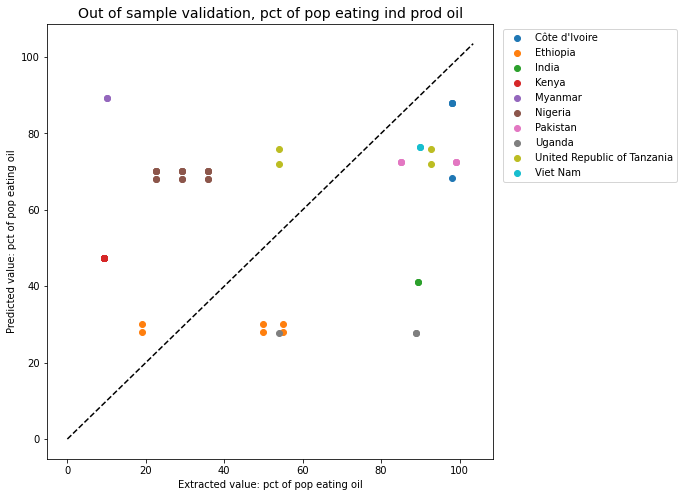

In [23]:
vehicle= "oil"

X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle,
                                                       use_logit = False)
total = pd.DataFrame()

loc = np.unique(notna_locs)[0]
for loc in np.unique(notna_locs)[1:]:
    holdout, preds, reg = runReg(X, y, notna_locs, loc)
    sub = pd.DataFrame({'holdout':y[holdout],'preds':preds,'location_name':loc})
    total = total.append(sub)

fig = plt.figure(figsize=(8,8))
for loc in total.location_name.unique():
    plt.scatter(total[total.location_name==loc].holdout,total[total.location_name==loc].preds, label= loc)
l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(100,r,t)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
plt.title(f"Out of sample validation, pct of pop eating ind prod {vehicle}", fontsize = 14)

plt.plot([lb,ub], [lb,ub], 'k--')

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Côte d'Ivoire


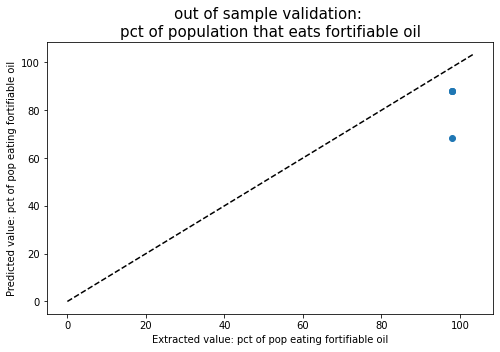

Ethiopia


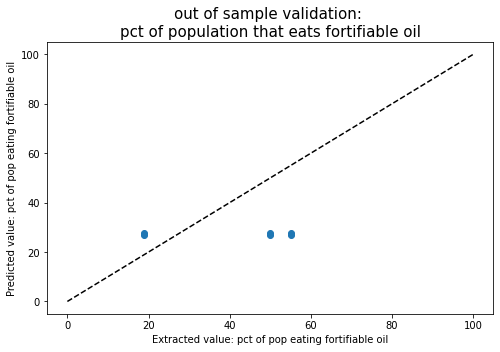

India


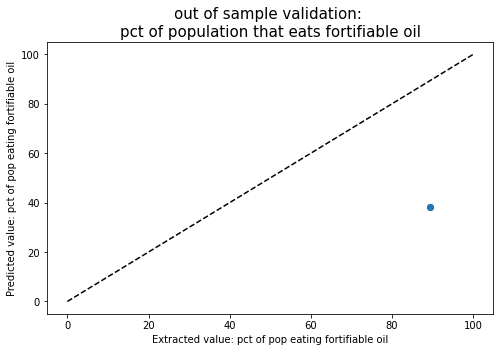

Kenya


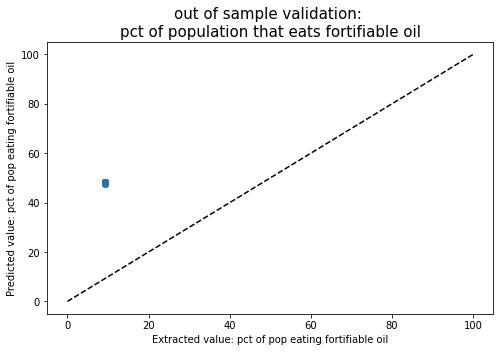

Myanmar


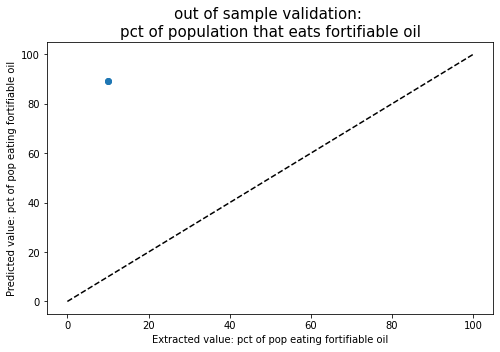

Nigeria


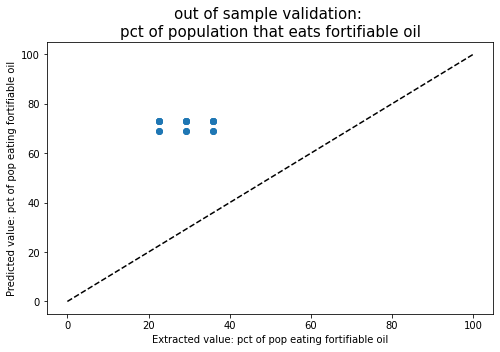

Pakistan


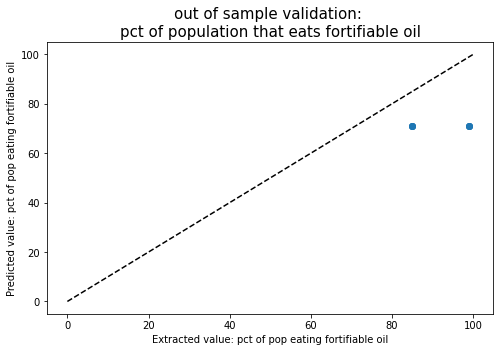

Uganda


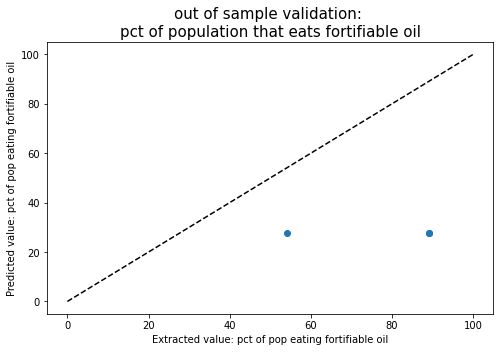

United Republic of Tanzania


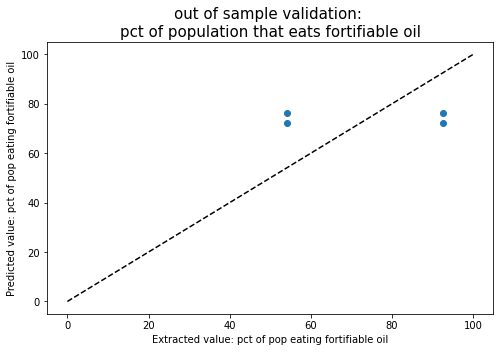

Viet Nam


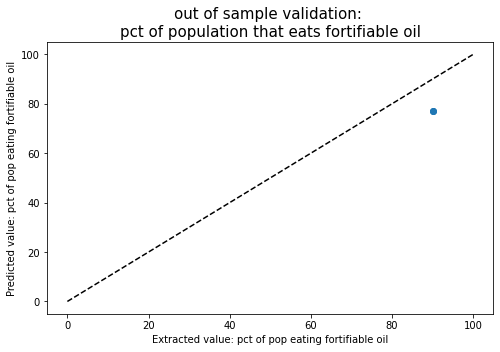

In [24]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "oil", use_logit = False)

loc = np.unique(notna_locs)[0]
holdout, preds, reg = runReg(X, y, notna_locs, loc)

loc = np.unique(notna_locs)[0]
for loc in np.unique(notna_locs)[1:]:
    print(loc)
    holdout, preds, reg= runReg(X, y, notna_locs, loc)
    fig = plt.figure(figsize=(8,5))
    plotReg(preds, holdout, False, "oil")
    plt.show()

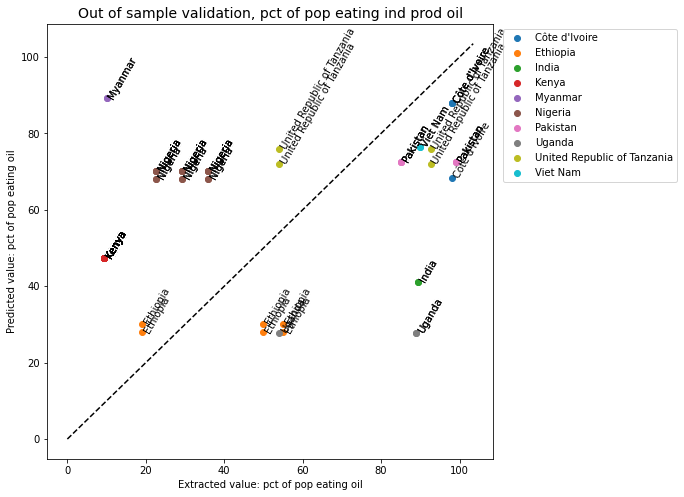

In [25]:
fig = plt.figure(figsize=(8,8))
for loc in total.location_name.unique():
    plt.scatter(total[total.location_name==loc].holdout,total[total.location_name==loc].preds, label= loc)
    for i in range(len(total[total.location_name==loc])):
        plt.annotate(loc, (total[total.location_name==loc].iloc[i].holdout,
                           total[total.location_name==loc].iloc[i].preds),
                    rotation=60)
l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(100,r,t)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.annotate("hello", (10,10))

plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
plt.title(f"Out of sample validation, pct of pop eating ind prod {vehicle}", fontsize = 14)
plt.plot([lb,ub], [lb,ub], 'k--')

In [26]:
def estimate_nans(df, vehicle, use_logit, clip = True):
    
    # format for regression
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    
    # run regression
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X, y)
    
    # predict out
    preds = reg.predict(X_full)
    
    # populate missings with estimates
    y_full[np.isnan(y_full)] = preds[np.isnan(y_full)] 
    
    return y_full
    
#     if use_logit:
#         y_full = (expit(y_full) + shift) * 100
    
#     if clip:
#         y_full = np.clip(y_full, 0, 100)
    
#     return pd.DataFrame({'location_name':full_locs,'vehicle':vehicle,'percent_of_population_eating_vehicle':y_full})

In [27]:
def estimate_w_uncertainty(vehicle, n):
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    
    estimates = np.vstack([estimate_nans(df, vehicle = vehicle, use_logit = False, clip = True) for i in range(n)])
    
    cols = [f'draw_{i}' for i in range(n)]

    out = pd.DataFrame(data = estimates.T, columns = cols)
    out['location_name'] = full_locs
    out['vehicle'] = vehicle
    
    return out[['location_name','vehicle'] + cols]

In [28]:
# %%time

# wheat_estimates = estimate_w_uncertainty(vehicle = "wheat flour", n = 500)

# save_wheat_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_fortifiable_wheat_regression_estimates_3_31_2021.csv'
# wheat_estimates.to_csv(save_wheat_estimates, index = False)

In [29]:
%%time

maize_estimates = estimate_w_uncertainty(vehicle = "maize flour", n = 500)

save_maize_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_fortifiable_maize_regression_estimates_3_31_2021.csv'
maize_estimates.to_csv(save_maize_estimates, index = False)

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

CPU times: user 11min 49s, sys: 529 ms, total: 11min 49s
Wall time: 11min 49s


In [30]:
# %%time

# oil_estimates = estimate_w_uncertainty(vehicle = "oil", 500)

# save_oil_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_fortifiable_oil_regression_estimates_3_31_2021.csv'
# oil_estimates.to_csv(save_oil_estimates, index = False)

In [31]:
# %%time

# wheat_estimates = estimate_w_uncertainty(vehicle = "wheat flour", n = 500)

# save_wheat_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_fortifiable_wheat_regression_estimates_3_26_2021.csv'
# wheat_estimates.to_csv(save_wheat_estimates, index = False)